# Pion Stop Regressor

This notebook mirrors the modern training utilities used by `classify_groups` and `group_splitter`.
It loads time-grouped pion hits, builds graph datasets with per-hit truth information,
and trains the reusable `PionStopRegressor` defined in `graph_data.models`.

In [7]:
import sys, os

PROJECT_ROOT = "/mnt/c/Users/obbee/research/notebooks/ML"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
    os.environ["PYTHONPATH"] = PROJECT_ROOT + os.pathsep + os.environ.get("PYTHONPATH", "")

In [16]:
import math
import glob
import re
from pathlib import Path
from typing import Any, Dict, List, Optional, Sequence, Tuple

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch_geometric.loader import DataLoader

from graph_data.utils import PionStopGraphDataset, PionStopRecord
from graph_data.models import PionStopRegressor

In [17]:
_CHUNK_INDEX_RE = re.compile(r"_(\d+)\.npy$")


def _extract_file_index(path: Path) -> Optional[int]:
    """Return numeric suffix from chunk filenames, if available."""
    match = _CHUNK_INDEX_RE.search(path.name)
    return int(match.group(1)) if match else None


def load_pion_stop_groups(
    file_pattern: str,
    *,
    pion_pdg: int = 1,
    max_files: Optional[int] = None,
    limit_groups: Optional[int] = None,
    min_hits: int = 3,
    min_pion_hits: int = 1,
    verbose: bool = True,
) -> List[Dict[str, Any]]:
    """Load preprocessed pion groups and emit dictionaries consumable by PionStopGraphDataset."""
    paths = [Path(p) for p in glob.glob(file_pattern)]
    if not paths:
        raise FileNotFoundError(f"No files matched pattern '{file_pattern}'")
    paths.sort(key=lambda p: (_extract_file_index(p) if _extract_file_index(p) is not None else math.inf, p.name))
    if max_files is not None:
        paths = paths[:max_files]

    records: List[Dict[str, Any]] = []
    total_groups = 0
    kept_groups = 0
    total_pion_hits = 0
    for path in paths:
        if limit_groups is not None and len(records) >= limit_groups:
            break

        chunk = np.load(path, allow_pickle=True)
        chunk_index = _extract_file_index(path) or 0

        for event_offset, event_groups in enumerate(chunk):
            if limit_groups is not None and len(records) >= limit_groups:
                break
            if event_groups is None or len(event_groups) == 0:
                continue

            for group_idx, raw_group in enumerate(event_groups):
                if limit_groups is not None and len(records) >= limit_groups:
                    break

                arr = np.asarray(raw_group)
                if arr.ndim != 2 or arr.shape[0] < min_hits or arr.shape[1] < 12:
                    continue

                pdgs = arr[:, 5].astype(int)

                allowed_mask = (pdgs == pion_pdg)
                if not np.all(allowed_mask):
                    continue

                pion_mask = pdgs == pion_pdg
                pion_hits = int(pion_mask.sum())
                total_groups += 1
                if pion_hits < min_pion_hits:
                    continue

                kept_groups += 1
                total_pion_hits += pion_hits

                record_event_id: Optional[int] = None
                try:
                    record_event_id = int(arr[0, 6])
                except (ValueError, TypeError):
                    record_event_id = None
                if record_event_id is None:
                    record_event_id = chunk_index * 100000 + event_offset

                records.append({
                    "coord": arr[:, 0].astype(np.float32),
                    "z": arr[:, 1].astype(np.float32),
                    "view": arr[:, 2].astype(np.float32),
                    "energy": arr[:, 3].astype(np.float32),
                    "time": arr[:, 4].astype(np.float32),
                    "pdg": pdgs.astype(np.int32),
                    "event_id": record_event_id,
                    "group_id": int(group_idx),
                    "true_x": arr[:, 7].astype(np.float32),
                    "true_y": arr[:, 8].astype(np.float32),
                    "true_z": arr[:, 9].astype(np.float32),
                    "true_time": arr[:, 10].astype(np.float32),
                })

    if verbose:
        print(
            f"Loaded {len(records)} pion groups across {len(paths)} files | "
            f"total groups={total_groups} kept={kept_groups} | total pion hits={total_pion_hits}"
        )

    return records

In [18]:

def _split_records(
    records: Sequence[Dict[str, Any] | PionStopRecord],
    *,
    train_fraction: float = 0.85,
    seed: int = 13,
) -> Tuple[List[Dict[str, Any] | PionStopRecord], List[Dict[str, Any] | PionStopRecord]]:
    if not records:
        return [], []
    rng = np.random.default_rng(seed)
    indices = np.arange(len(records))
    rng.shuffle(indices)
    if len(indices) == 1:
        return [records[int(indices[0])]], []
    split = int(len(indices) * train_fraction)
    split = min(max(split, 1), len(indices) - 1)
    train_idx = indices[:split]
    val_idx = indices[split:]
    return [records[i] for i in train_idx], [records[i] for i in val_idx]


def _make_loaders(
    records: Sequence[Dict[str, Any] | PionStopRecord],
    *,
    batch_size: int,
    train_fraction: float,
    seed: int,
    pion_pdg: int,
    min_pion_hits: int,
    use_true_time: bool,
):
    train_records, val_records = _split_records(records, train_fraction=train_fraction, seed=seed)
    if not train_records:
        raise ValueError("Training set is empty. Check filtering parameters.")

    train_dataset = PionStopGraphDataset(
        train_records,
        pion_pdg=pion_pdg,
        min_pion_hits=min_pion_hits,
        use_true_time=use_true_time,
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_loader = None
    val_dataset = None
    if val_records:
        val_dataset = PionStopGraphDataset(
            val_records,
            pion_pdg=pion_pdg,
            min_pion_hits=min_pion_hits,
            use_true_time=use_true_time,
        )
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, train_dataset, val_dataset


def _distance_histogram(distances: np.ndarray | Sequence[float], bins: int = 50, span=(0.0, 2.0)):
    values = np.asarray(distances, dtype=np.float32)
    if values.size == 0:
        return None
    counts, edges = np.histogram(values, bins=bins, range=span)
    return {
        'counts': counts.tolist(),
        'bin_edges': edges.tolist(),
    }


def _plot_histogram(title: str, hist_data: Optional[Dict[str, Any]]) -> None:
    if hist_data is None:
        return
    counts = np.asarray(hist_data['counts'], dtype=np.float32)
    edges = np.asarray(hist_data['bin_edges'], dtype=np.float32)
    if counts.size == 0 or edges.size == 0:
        return
    centers = 0.5 * (edges[:-1] + edges[1:])
    widths = np.diff(edges)
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    for ax, log_scale in zip(axes, [False, True]):
        ax.bar(centers, counts, width=widths, align='center', alpha=0.75, color='teal')
        ax.set_title(f"{title} pion-stop error histogram" + (' (log)' if log_scale else ''))
        ax.set_xlabel('Euclidean error [mm]')
        ax.set_ylabel('Counts')
        ax.set_xlim(0.0, 2.0)
        if log_scale:
            ax.set_yscale('log')
        ax.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


def _run_train_epoch(model, loader, optimizer, loss_fn, device, grad_clip=None):
    model.train()
    total_loss = 0.0
    total_distance = 0.0
    total_samples = 0
    distance_values: list[torch.Tensor] = []

    for data in loader:
        data = data.to(device)
        target = data.y.view(data.num_graphs, -1).float()
        preds = model(data)
        loss = loss_fn(preds, target)

        optimizer.zero_grad()
        loss.backward()
        if grad_clip is not None and grad_clip > 0:
            clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        batch_dist = torch.norm(preds - target, dim=1).detach()
        distance_values.append(batch_dist.cpu())

        batch_size = target.size(0)
        total_loss += loss.item() * batch_size
        total_distance += batch_dist.sum().item()
        total_samples += batch_size

    mean_loss = total_loss / max(total_samples, 1)
    mean_distance = total_distance / max(total_samples, 1)
    all_distances = torch.cat(distance_values).numpy() if distance_values else np.zeros(0, dtype=np.float32)
    return mean_loss, mean_distance, all_distances


def _run_eval_epoch(model, loader, loss_fn, device):
    if loader is None:
        return math.nan, math.nan, np.zeros(0, dtype=np.float32)

    model.train()
    total_loss = 0.0
    total_distance = 0.0
    total_samples = 0
    distance_values: list[torch.Tensor] = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            target = data.y.view(data.num_graphs, -1).float()
            preds = model(data)
            loss = loss_fn(preds, target)

            batch_dist = torch.norm(preds - target, dim=1).detach()
            distance_values.append(batch_dist.cpu())

            batch_size = target.size(0)
            total_loss += loss.item() * batch_size
            total_distance += batch_dist.sum().item()
            total_samples += batch_size

    mean_loss = total_loss / max(total_samples, 1)
    mean_distance = total_distance / max(total_samples, 1)
    all_distances = torch.cat(distance_values).numpy() if distance_values else np.zeros(0, dtype=np.float32)
    return mean_loss, mean_distance, all_distances


def train_pion_stop_regressor(
    records: Sequence[Dict[str, Any] | PionStopRecord],
    *,
    model: Optional[torch.nn.Module] = None,
    batch_size: int = 128,
    epochs: int = 20,
    lr: float = 5e-4,
    weight_decay: float = 1e-5,
    train_fraction: float = 0.85,
    seed: int = 13,
    grad_clip: Optional[float] = 2.0,
    scheduler_step_size: Optional[int] = None,
    scheduler_gamma: float = 0.7,
    pion_pdg: int = 1,
    min_pion_hits: int = 1,
    use_true_time: bool = True,
    device: Optional[torch.device | str] = None,
):
    if model is None:
        model = PionStopRegressor()

    device_obj = torch.device(device) if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device_obj)

    train_loader, val_loader, train_dataset, val_dataset = _make_loaders(
        records,
        batch_size=batch_size,
        train_fraction=train_fraction,
        seed=seed,
        pion_pdg=pion_pdg,
        min_pion_hits=min_pion_hits,
        use_true_time=use_true_time,
    )

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = None
    if scheduler_step_size is not None and scheduler_step_size > 0:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

    history = []
    for epoch in range(1, epochs + 1):
        current_lr = optimizer.param_groups[0]['lr']
        train_loss, train_dist, train_dists = _run_train_epoch(model, train_loader, optimizer, loss_fn, device_obj, grad_clip)
        val_loss, val_dist, val_dists = _run_eval_epoch(model, val_loader, loss_fn, device_obj)

        if scheduler is not None:
            scheduler.step()

        train_hist = _distance_histogram(train_dists)
        val_hist = _distance_histogram(val_dists) if not math.isnan(val_loss) else None

        _plot_histogram('Train', train_hist)
        if val_hist is not None:
            _plot_histogram('Validation', val_hist)

        if not math.isnan(val_loss):
            print(
                f"Epoch {epoch:02d} | lr={current_lr:.5f} | train_loss={train_loss:.5f} dist={train_dist:.5f} | "
                f"val_loss={val_loss:.5f} dist={val_dist:.5f}"
            )
        else:
            print(
                f"Epoch {epoch:02d} | lr={current_lr:.5f} | train_loss={train_loss:.5f} dist={train_dist:.5f}"
            )

        history.append({
            'epoch': epoch,
            'lr': float(current_lr),
            'train_loss': float(train_loss),
            'train_distance': float(train_dist),
            'train_histogram': train_hist,
            'val_loss': None if math.isnan(val_loss) else float(val_loss),
            'val_distance': None if math.isnan(val_dist) else float(val_dist),
            'val_histogram': val_hist,
        })

    return {
        'model': model,
        'history': history,
        'train_size': len(train_dataset),
        'val_size': 0 if val_dataset is None else len(val_dataset),
    }


Loaded 36925 pion groups across 4 files | total groups=36925 kept=36925 | total pion hits=1049407


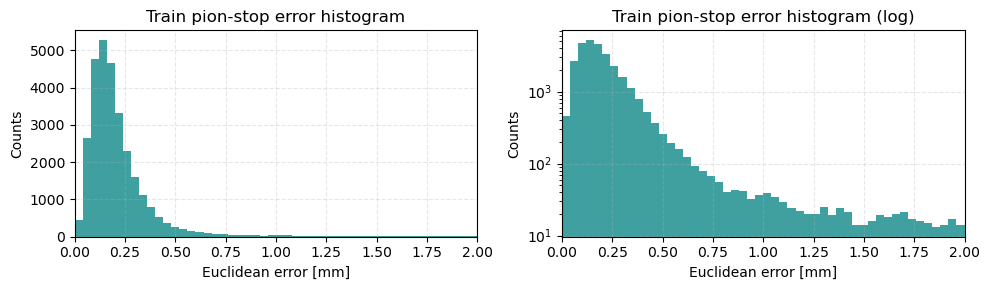

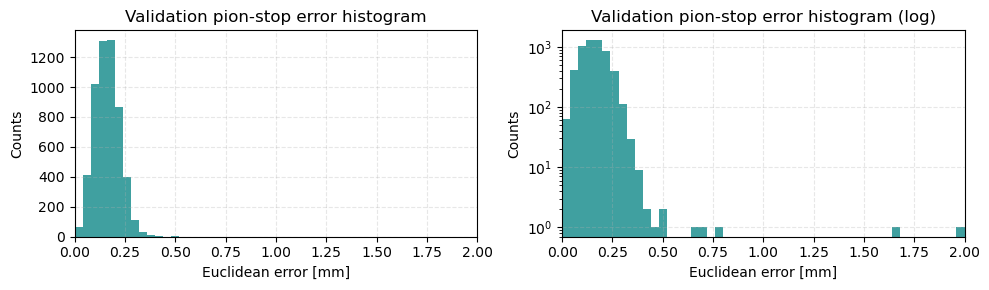

Epoch 01 | lr=0.00100 | train_loss=0.55088 dist=0.49557 | val_loss=0.01072 dist=0.16212


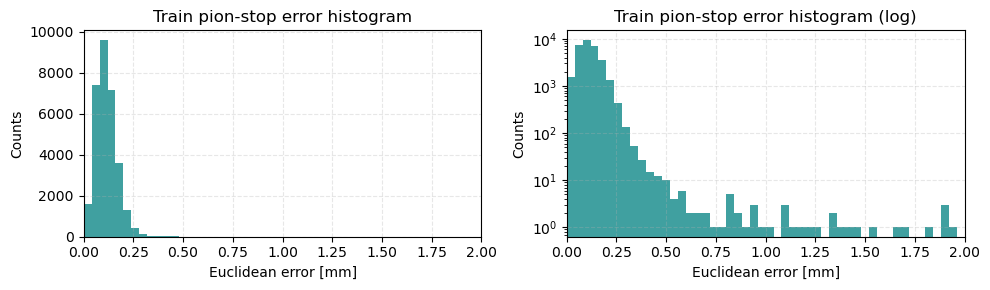

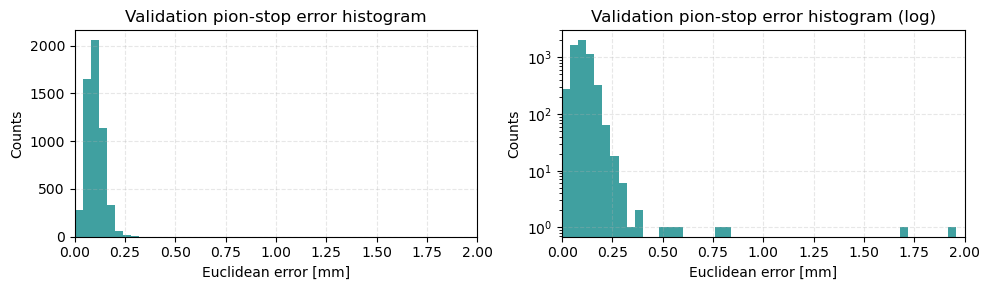

Epoch 02 | lr=0.00100 | train_loss=0.00647 dist=0.11618 | val_loss=0.00475 dist=0.10080


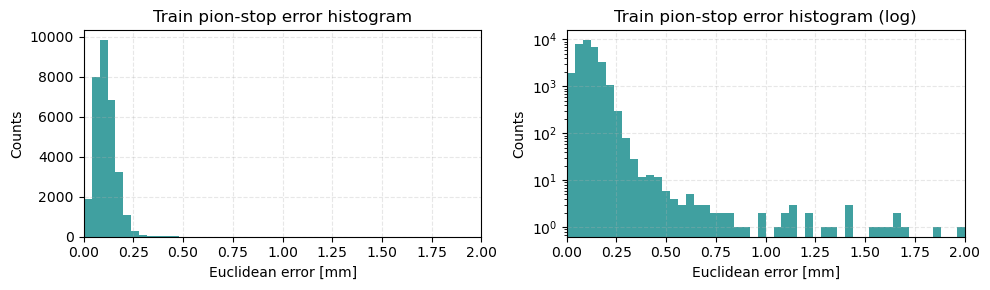

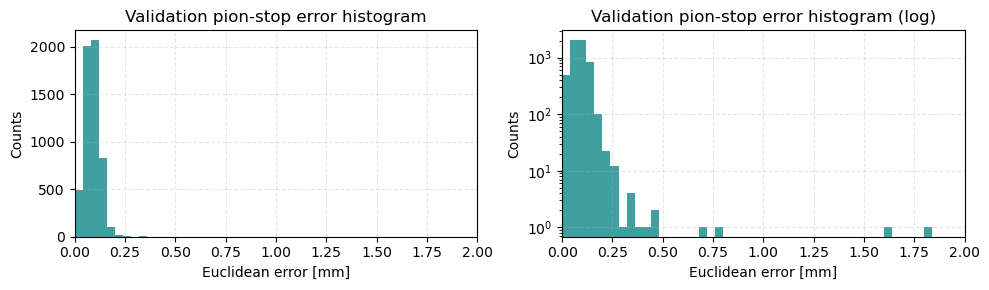

Epoch 03 | lr=0.00100 | train_loss=0.00631 dist=0.11083 | val_loss=0.00375 dist=0.08821


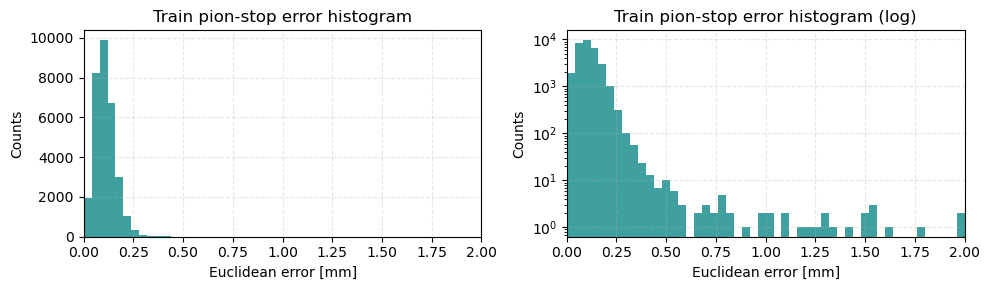

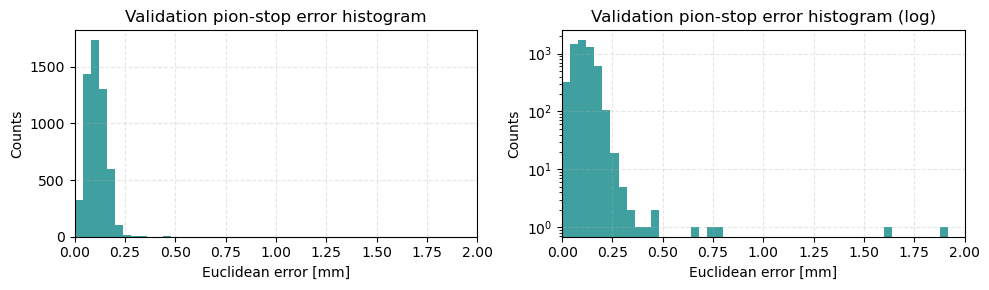

Epoch 04 | lr=0.00100 | train_loss=0.00711 dist=0.11025 | val_loss=0.00529 dist=0.10789


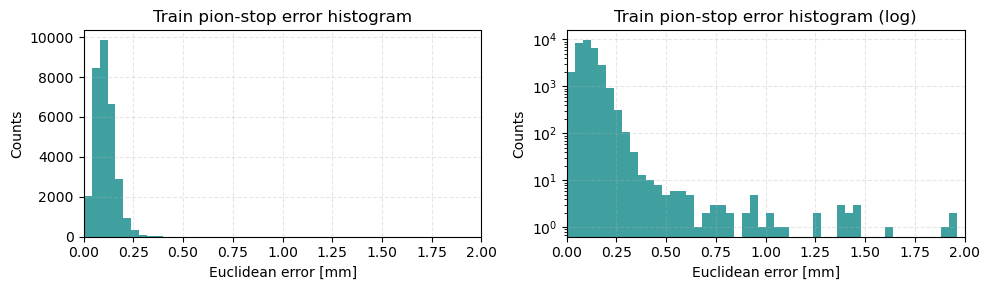

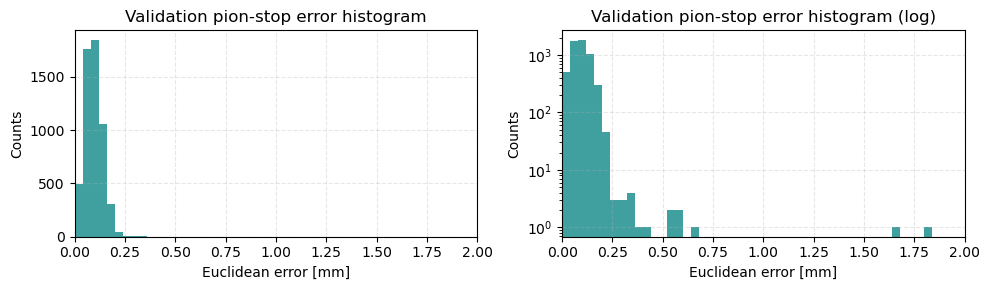

Epoch 05 | lr=0.00100 | train_loss=0.00690 dist=0.10927 | val_loss=0.00428 dist=0.09484


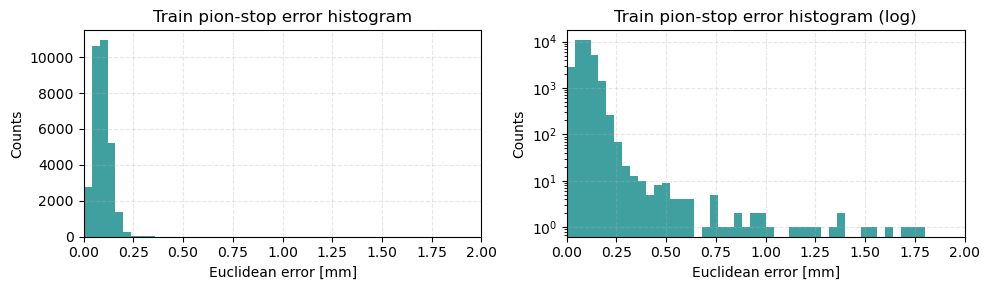

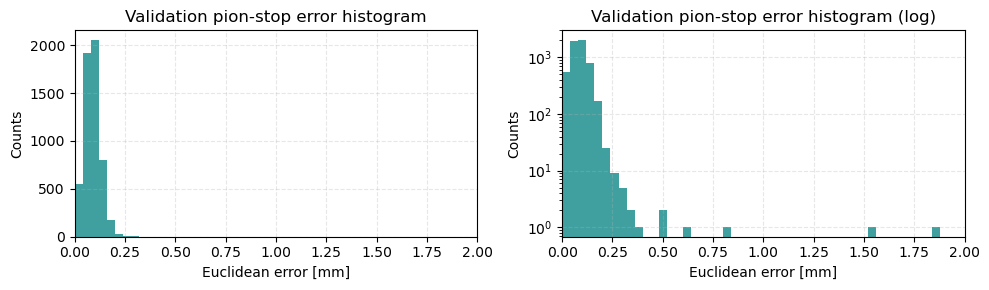

Epoch 06 | lr=0.00050 | train_loss=0.00406 dist=0.09298 | val_loss=0.00387 dist=0.08893


KeyboardInterrupt: 

In [ ]:
FILE_PATTERN = '/mnt/e/testML/pimuTimeGroups/mainTimeGroups_*.npy'

pion_groups = load_pion_stop_groups(
    FILE_PATTERN,
    max_files=10,
    limit_groups=100000,
    min_hits=2,
    min_pion_hits=3,
)

pion_model = PionStopRegressor(in_channels=5, hidden=150, heads=5, layers=3, dropout=0.15)

results = train_pion_stop_regressor(
    pion_groups,
    model=pion_model,
    batch_size=32,
    epochs=20,
    lr=1e-3,
    weight_decay=1e-5,
    train_fraction=0.85,
    seed=123,
    grad_clip=2.0,
    scheduler_step_size=5,
    scheduler_gamma=0.5,
)

print(f"Train groups: {results['train_size']} | Val groups: {results['val_size']}")
for entry in results['history']:
    val_part = ''
    if entry['val_loss'] is not None:
        val_part = f" | val_loss={entry['val_loss']:.5f} dist={entry['val_distance']:.5f}"
    print(
        f"Epoch {entry['epoch']:02d}: train_loss={entry['train_loss']:.5f} dist={entry['train_distance']:.5f}{val_part}"
    )

In [ ]:
for group in pion_groups:
    thePDGs = group['pdg']
    if 1 not in thePDGs:
        print("Found no pion hit in group PDGs:", thePDGs)
